In [1]:
# ============================================
# 📦 Step 1: Import Libraries
# ============================================

import warnings
warnings.filterwarnings('ignore')

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import cv2
import random
from tqdm import tqdm
from pathlib import Path
import kagglehub
from scipy import ndimage
from scipy.ndimage import rotate as scipy_rotate

# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# ============================================
# 📁 Step 2: Download and Load Dataset
# ============================================

path = kagglehub.dataset_download("khanfashee/nih-chest-x-ray-14-224x224-resized")
BASE_PATH = Path(path)
print(f"📂 Dataset path: {BASE_PATH}")

df_labels = pd.read_csv(BASE_PATH / "Data_Entry_2017.csv")
images_dir = BASE_PATH / "images-224" / "images-224"
df_labels["Image Path"] = [str(images_dir / p) for p in df_labels["Image Index"].values]

DISEASE_CATEGORIES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

for disease in DISEASE_CATEGORIES:
    df_labels[disease] = df_labels['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

# Validate sample images
sample_paths = df_labels['Image Path'].sample(200, random_state=42).values
missing = [p for p in sample_paths if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f"❌ Missing {len(missing)} images! First 3: {missing[:3]}")

print(f"✅ Loaded {len(df_labels):,} images")
print(f"📊 Disease categories: {len(DISEASE_CATEGORIES)}")

📂 Dataset path: /kaggle/input/nih-chest-x-ray-14-224x224-resized
✅ Loaded 112,120 images
📊 Disease categories: 14


In [ ]:
# ============================================
# ⚙️ Step 3: Configuration
# ============================================

class Config:
    # Model
    img_size = 224
    feat_dim = 256
    proj_dim = 128
    
    # Training
    batch_size = 32
    pretrain_epochs = 25
    finetune_epochs = 30
    lr_pretrain = 5e-4
    lr_finetune = 5e-5
    temperature = 0.1
    mask_weight = 0.3  # Weight for mask-based loss modulation
    
    # Data
    num_workers = 4
    use_subset = False
    subset_size = 10000
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cfg = Config()

print("⚙️ Configuration:")
print(f"   Device: {cfg.device}")
print(f"   Batch size: {cfg.batch_size}")
print(f"   Mask weight: {cfg.mask_weight}")

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

⚙️ Configuration:
   Device: cuda
   Batch size: 32
   Mask weight: 0.3
   GPU: Tesla P100-PCIE-16GB


In [ ]:
# ============================================
# 💾 Step 3.5: Checkpoint & Resume Configuration
# ============================================
# ⚠️ EDIT THIS SECTION WHEN RESUMING AFTER DAYS/WEEKS

import os
import shutil
from datetime import datetime

# ╔══════════════════════════════════════════════════════════════╗
# ║  🔧 RESUME CONFIGURATION - EDIT THESE VALUES WHEN RESUMING  ║
# ╚══════════════════════════════════════════════════════════════╝

# ===== STEP 1: Set your checkpoint dataset name =====
# After your first run, save outputs as dataset and put the name here
# ⚠️ Use the EXACT name (lowercase, hyphens) - check /kaggle/input/
CHECKPOINT_DATASET_NAME = "chest-xray-ssl-checkpoints"  # Your dataset name

# ===== STEP 2: Set resume flags =====
RESUME_SSL_PRETRAINING = True   # Set True to resume SSL pretraining
RESUME_FINETUNING = False        # Set True to resume fine-tuning

# ===== STEP 3: If resuming, specify which checkpoint to load =====
# Leave as "latest" to auto-detect, or specify: "option1_ssl_epoch20.pth"
SSL_CHECKPOINT_FILE = "latest"
FINETUNE_CHECKPOINT_FILE = "latest"

# ╔══════════════════════════════════════════════════════════════╗
# ║                    END OF USER CONFIG                        ║
# ╚══════════════════════════════════════════════════════════════╝

# Detect environment
IN_KAGGLE = os.path.exists('/kaggle')
IN_COLAB = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    CHECKPOINT_DIR = '/content/drive/MyDrive/chest_xray_ssl'
    IN_COLAB = True
except:
    pass

# ===== DEBUG: Show all available input datasets =====
if IN_KAGGLE:
    print("🔍 DEBUG: Checking available input datasets...")
    print("="*60)
    
    input_path = '/kaggle/input'
    if os.path.exists(input_path):
        datasets = os.listdir(input_path)
        if datasets:
            print(f"📂 Found {len(datasets)} input dataset(s):")
            for ds in sorted(datasets):
                ds_path = os.path.join(input_path, ds)
                files = os.listdir(ds_path) if os.path.isdir(ds_path) else []
                pth_files = [f for f in files if f.endswith('.pth')]
                print(f"   • {ds}/")
                if pth_files:
                    print(f"     └── 📦 Checkpoints: {pth_files}")
                else:
                    print(f"     └── (no .pth files)")
        else:
            print("❌ No input datasets found!")
            print("   Did you add your checkpoint dataset as Input?")
    
    print("="*60)
    
    # Check if the configured dataset exists
    PREV_CHECKPOINT_DIR = f'/kaggle/input/{CHECKPOINT_DATASET_NAME}'
    CHECKPOINT_DIR = '/kaggle/working/checkpoints'
    
    if os.path.exists(PREV_CHECKPOINT_DIR):
        print(f"✅ Found checkpoint dataset: {CHECKPOINT_DATASET_NAME}")
        pth_files = [f for f in os.listdir(PREV_CHECKPOINT_DIR) if f.endswith('.pth')]
        print(f"   📦 Checkpoint files: {pth_files}")
        
        # Auto-copy previous checkpoints
        os.makedirs(CHECKPOINT_DIR, exist_ok=True)
        copied = 0
        for f in os.listdir(PREV_CHECKPOINT_DIR):
            if f.endswith('.pth'):
                src = os.path.join(PREV_CHECKPOINT_DIR, f)
                dst = os.path.join(CHECKPOINT_DIR, f)
                if not os.path.exists(dst):
                    shutil.copy2(src, dst)
                    copied += 1
        print(f"   ✅ Copied {copied} checkpoint files to working directory")
    else:
        print(f"❌ Checkpoint dataset NOT FOUND: {CHECKPOINT_DATASET_NAME}")
        print(f"   Expected path: {PREV_CHECKPOINT_DIR}")
        print("\n🔧 TO FIX THIS:")
        print("   1. Go to your notebook's right panel → 'Add Input'")
        print("   2. Click 'Your Datasets' tab")
        print("   3. Find and add your checkpoint dataset")
        print(f"   4. Make sure the name matches: '{CHECKPOINT_DATASET_NAME}'")
        print("   5. Re-run this cell")
        
elif not IN_COLAB:
    CHECKPOINT_DIR = './checkpoints'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ===== CHECKPOINT UTILITIES =====
def save_checkpoint(state, filename):
    """Save checkpoint with timestamp"""
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    state['saved_at'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    torch.save(state, filepath)
    print(f"💾 Saved: {filename}")
    
    if IN_KAGGLE:
        # Also save to root /kaggle/working/ for easy access
        torch.save(state, f'/kaggle/working/{filename}')

def load_checkpoint(filename):
    """Load checkpoint from storage"""
    filepath = os.path.join(CHECKPOINT_DIR, filename)
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath, map_location=cfg.device)
        saved_at = checkpoint.get('saved_at', 'Unknown')
        print(f"✅ Loaded: {filename} (saved: {saved_at})")
        return checkpoint
    print(f"⚠️ Not found: {filepath}")
    return None

def find_latest_checkpoint(prefix):
    """Find the most recent checkpoint with given prefix"""
    if not os.path.exists(CHECKPOINT_DIR):
        return None
    
    # First check for 'latest' checkpoint
    latest_file = f'{prefix}_latest.pth'
    if os.path.exists(os.path.join(CHECKPOINT_DIR, latest_file)):
        return latest_file
    
    # Otherwise find highest epoch number
    import re
    pattern = re.compile(rf'{prefix}_epoch(\d+)\.pth')
    max_epoch = -1
    best_file = None
    
    for f in os.listdir(CHECKPOINT_DIR):
        match = pattern.match(f)
        if match:
            epoch = int(match.group(1))
            if epoch > max_epoch:
                max_epoch = epoch
                best_file = f
    
    return best_file

def list_checkpoints():
    """List all available checkpoints with details"""
    print(f"\n📁 Checkpoints in {CHECKPOINT_DIR}:")
    if not os.path.exists(CHECKPOINT_DIR):
        print("   (empty)")
        return []
    
    files = sorted([f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')])
    if not files:
        print("   (empty)")
        return []
    
    for f in files:
        filepath = os.path.join(CHECKPOINT_DIR, f)
        size = os.path.getsize(filepath) / (1024*1024)
        try:
            ckpt = torch.load(filepath, map_location='cpu')
            epoch = ckpt.get('epoch', '?')
            saved_at = ckpt.get('saved_at', 'Unknown')
            print(f"   📦 {f} | Epoch {epoch} | {size:.1f}MB | {saved_at}")
        except:
            print(f"   📦 {f} | {size:.1f}MB")
    return files

def get_training_status():
    """Get current training progress"""
    ssl_ckpt = find_latest_checkpoint('option1_ssl')
    ft_ckpt = find_latest_checkpoint('option1_finetune')
    
    print("\n" + "="*60)
    print("📊 TRAINING STATUS")
    print("="*60)
    
    if ssl_ckpt:
        ckpt = torch.load(os.path.join(CHECKPOINT_DIR, ssl_ckpt), map_location='cpu')
        ssl_epoch = ckpt.get('epoch', 0)
        print(f"SSL Pretraining: Epoch {ssl_epoch}/{cfg.pretrain_epochs} "
              f"({'COMPLETE ✅' if ssl_epoch >= cfg.pretrain_epochs else 'IN PROGRESS'})")
    else:
        print("SSL Pretraining: NOT STARTED")
        ssl_epoch = 0
    
    if ft_ckpt:
        ckpt = torch.load(os.path.join(CHECKPOINT_DIR, ft_ckpt), map_location='cpu')
        ft_epoch = ckpt.get('epoch', 0)
        best_auc = ckpt.get('best_val_auc', 0)
        print(f"Fine-tuning: Epoch {ft_epoch}/{cfg.finetune_epochs} "
              f"({'COMPLETE ✅' if ft_epoch >= cfg.finetune_epochs else 'IN PROGRESS'})")
        print(f"Best Val AUC: {best_auc:.4f}")
    else:
        print("Fine-tuning: NOT STARTED")
    
    print("="*60)

# Show current status
print(f"\n🔧 Environment: {'Kaggle' if IN_KAGGLE else 'Colab' if IN_COLAB else 'Local'}")
print(f"📂 Checkpoint directory: {CHECKPOINT_DIR}")
list_checkpoints()
get_training_status()

print("\n" + "="*60)
print("📌 CHECKLIST FOR RESUMING:")
print("="*60)
print("""
✅ Step 1: After first run, click 'Save Version' → 'Quick Save'
✅ Step 2: Go to Output tab → '+ New Dataset' → name it
✅ Step 3: In NEW session, click 'Add Input' (right panel)
✅ Step 4: Select 'Your Datasets' → Add your checkpoint dataset
✅ Step 5: Update CHECKPOINT_DATASET_NAME above to match EXACTLY
✅ Step 6: Set RESUME_SSL_PRETRAINING = True
✅ Step 7: Run notebook!
""")
print("="*60)

ℹ️ No previous checkpoints found at: /kaggle/input/chest-xray-ssl-checkpoints
   (This is normal for first run)
🔧 Environment: Kaggle
📂 Checkpoint directory: /kaggle/working/checkpoints

📁 Checkpoints in /kaggle/working/checkpoints:
   (empty)

📊 TRAINING STATUS
SSL Pretraining: NOT STARTED
Fine-tuning: NOT STARTED

📌 HOW TO RESUME AFTER DAYS/WEEKS:

1️⃣  FIRST RUN (Fresh start):
   • Run entire notebook
   • Checkpoints auto-save to /kaggle/working/
   • When done: Save Version → Quick Save

2️⃣  SAVE CHECKPOINTS AS DATASET:
   • Go to notebook Output tab
   • Click '+ New Dataset'
   • Name it (e.g., 'chest-xray-ssl-checkpoints')

3️⃣  NEXT SESSION (Resume):
   • Add your checkpoint dataset as Input
   • Update CHECKPOINT_DATASET_NAME above
   • Set RESUME_SSL_PRETRAINING = True (or RESUME_FINETUNING)
   • Run notebook - it will auto-resume!

4️⃣  REPEAT steps 2-3 until training complete



In [ ]:
# ============================================
# 🫁 Step 4: Lung Segmentation Function
# ============================================

def simple_lung_segmentation(image):
    """
    Rule-based lung field segmentation using Otsu + morphology
    
    Args:
        image: Grayscale chest X-ray (H, W) or (1, H, W), values in [0, 1]
    
    Returns:
        lung_mask: Binary mask where 1 = lung tissue, 0 = background
    """
    if len(image.shape) == 3 and image.shape[0] == 1:
        image = image[0]
    
    img_uint8 = (image * 255).astype(np.uint8)
    
    # Otsu thresholding - lungs are darker than surroundings
    _, binary = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = 255 - binary  # Invert: dark lungs → white
    
    # Morphological cleanup
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    
    lung_mask = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_large)
    lung_mask = cv2.morphologyEx(lung_mask, cv2.MORPH_OPEN, kernel_small)
    
    # Keep only 2 largest components (left/right lungs)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(lung_mask, connectivity=8)
    
    if num_labels > 1:
        sizes = stats[1:, cv2.CC_STAT_AREA]
        num_keep = min(2, len(sizes))
        largest = np.argsort(sizes)[-num_keep:] + 1
        final_mask = np.isin(labels, largest).astype(np.uint8) * 255
    else:
        final_mask = lung_mask
    
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel_large)
    
    return final_mask.astype(np.float32) / 255.0

print("✅ Lung segmentation function defined")

✅ Lung segmentation function defined


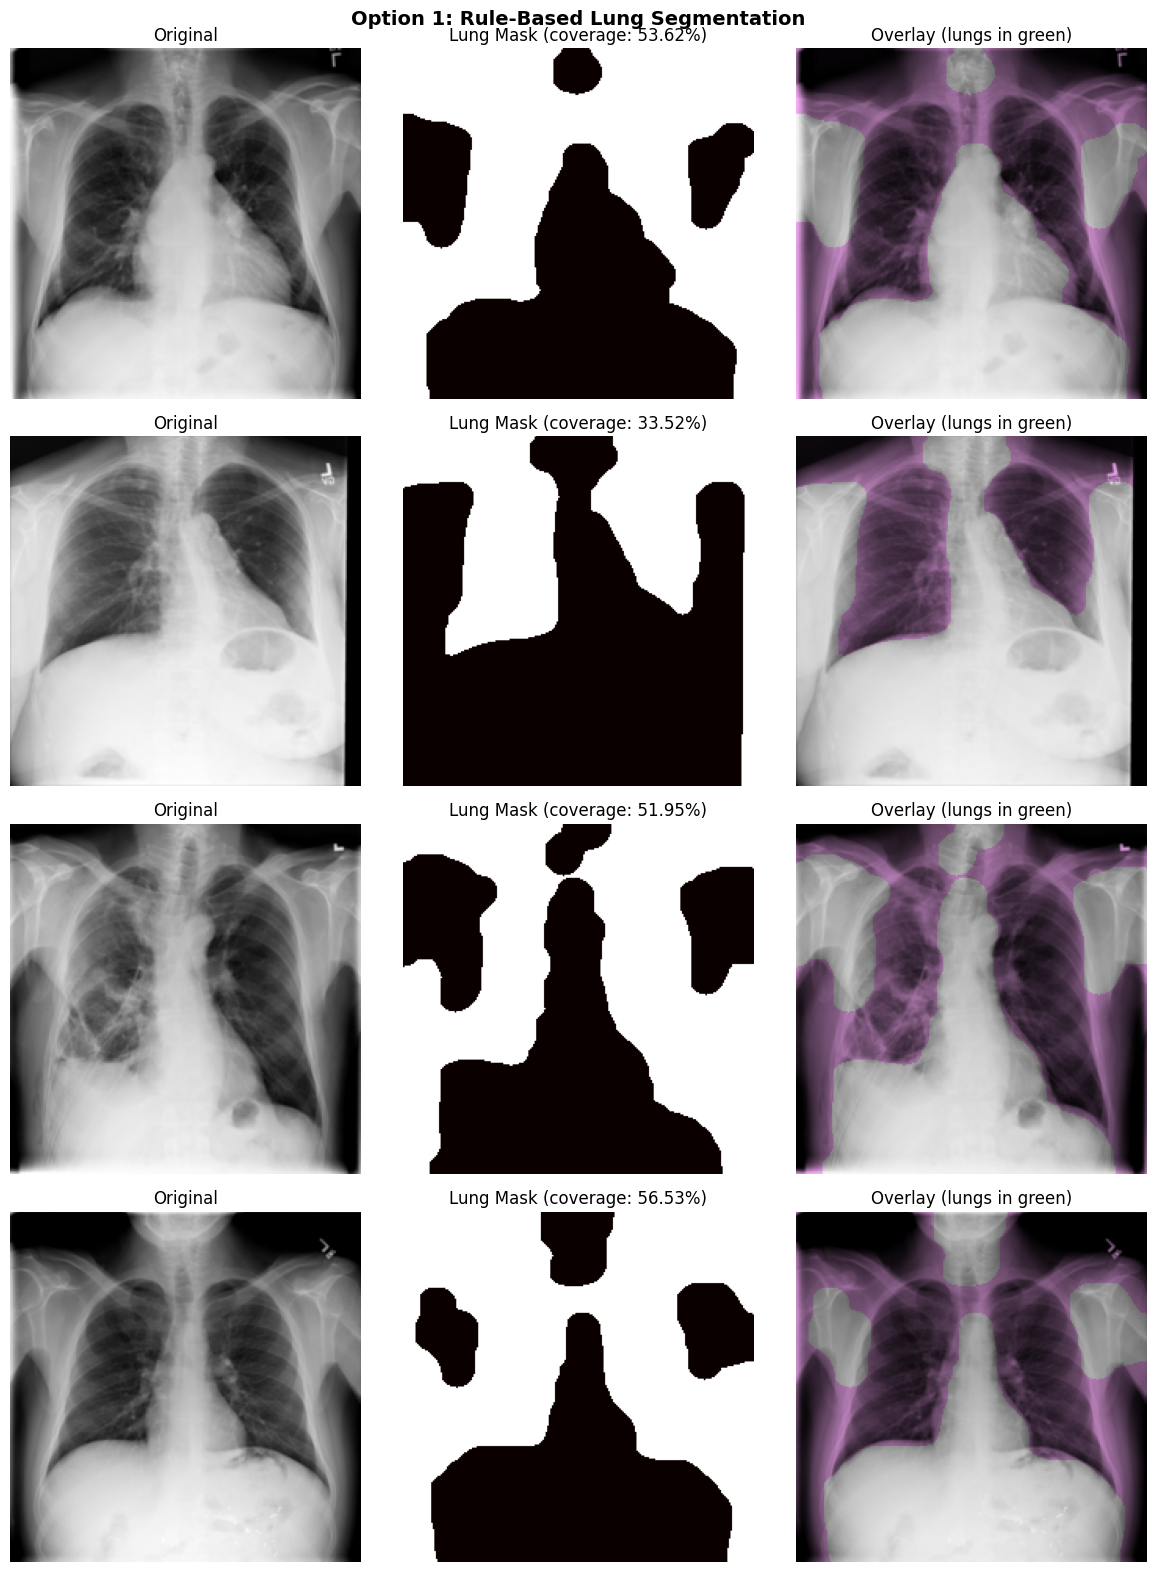

In [6]:
# ============================================
# 👁️ Step 5: Visualize Lung Segmentation
# ============================================

# Test segmentation on sample images
sample_indices = [0, 100, 500, 1000]
fig, axes = plt.subplots(len(sample_indices), 3, figsize=(12, 4*len(sample_indices)))

for i, idx in enumerate(sample_indices):
    img_path = df_labels.iloc[idx]['Image Path']
    img = Image.open(img_path).convert('L')
    img = img.resize((cfg.img_size, cfg.img_size), Image.LANCZOS)
    img_np = np.array(img, dtype=np.float32) / 255.0
    
    # Get segmentation
    mask = simple_lung_segmentation(img_np)
    
    # Plot
    axes[i, 0].imshow(img_np, cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='hot')
    axes[i, 1].set_title(f'Lung Mask (coverage: {mask.mean():.2%})')
    axes[i, 1].axis('off')
    
    # Overlay
    overlay = np.stack([img_np, img_np * (1 - 0.3*mask), img_np], axis=-1)
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay (lungs in green)')
    axes[i, 2].axis('off')

plt.suptitle('Option 1: Rule-Based Lung Segmentation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option1_segmentation_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# ============================================
# 🔄 Step 6: Augmentation
# ============================================

class ChestXrayAugment:
    """Augmentations for contrastive learning"""
    
    def __init__(self, img_size=224):
        self.img_size = img_size
    
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            x = torch.tensor(img, dtype=torch.float32)
        else:
            x = img.clone()
        
        if random.random() < 0.5:
            x = torch.flip(x, dims=[2])
        
        if random.random() < 0.7:
            angle = random.uniform(-15, 15)
            x = transforms.functional.rotate(x, angle)
        
        if random.random() < 0.8:
            factor = 1 + random.uniform(-0.2, 0.2)
            x = transforms.functional.adjust_brightness(x, factor)
        
        if random.random() < 0.8:
            factor = 1 + random.uniform(-0.2, 0.2)
            x = transforms.functional.adjust_contrast(x, factor)
        
        if random.random() < 0.5:
            noise = torch.randn_like(x) * 0.05
            x = torch.clamp(x + noise, 0, 1)
        
        return x

augment = ChestXrayAugment(cfg.img_size)
print("✅ Augmentation pipeline ready")

✅ Augmentation pipeline ready


In [8]:
# ============================================
# 📦 Step 7: Dataset Classes
# ============================================

class MaskedPretrainDataset(Dataset):
    """Dataset for masked contrastive SSL pretraining"""
    
    def __init__(self, df, transform=None, img_size=224):
        self.df = df.copy().reset_index(drop=True)
        self.transform = transform
        self.img_size = img_size
        
        # Validate samples
        sample_paths = self.df['Image Path'].sample(min(200, len(self.df)), random_state=42).values
        missing = [p for p in sample_paths if not os.path.exists(p)]
        if missing:
            raise FileNotFoundError(f"❌ Missing {len(missing)} images!")
        
        print(f"📦 MaskedPretrainDataset: {len(self.df)} samples")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Image Path']
        
        # Load image
        img = Image.open(img_path).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.expand_dims(img, 0)  # (1, H, W)
        
        # Generate lung mask
        lung_mask = simple_lung_segmentation(img)
        lung_mask = np.expand_dims(lung_mask, 0)  # (1, H, W)
        
        # Create augmented views
        if self.transform:
            view1 = self.transform(img)
            view2 = self.transform(img)
        else:
            view1 = torch.tensor(img, dtype=torch.float32)
            view2 = torch.tensor(img, dtype=torch.float32)
        
        mask1 = torch.tensor(lung_mask, dtype=torch.float32)
        mask2 = torch.tensor(lung_mask, dtype=torch.float32)
        
        return view1, view2, mask1, mask2


class ClassificationDataset(Dataset):
    """Dataset for multi-label classification"""
    
    def __init__(self, df, disease_categories, img_size=224):
        self.df = df.copy().reset_index(drop=True)
        self.disease_categories = disease_categories
        self.img_size = img_size
        print(f"📦 ClassificationDataset: {len(self.df)} samples")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['Image Path']).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.LANCZOS)
        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        
        labels = torch.tensor([row[d] for d in self.disease_categories], dtype=torch.float32)
        return img, labels

print("✅ Dataset classes defined")

✅ Dataset classes defined


In [9]:
# ============================================
# 🏗️ Step 8: Model Architecture
# ============================================

def conv_block(in_c, out_c, kernel=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel, stride, padding),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

def residual_block(channels):
    return nn.Sequential(
        conv_block(channels, channels),
        conv_block(channels, channels)
    )


class Encoder(nn.Module):
    """CNN Encoder for feature extraction"""
    
    def __init__(self, in_channels=1, feat_dim=256):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(in_channels, 64),
            residual_block(64),
            nn.MaxPool2d(2),
            
            conv_block(64, 128),
            residual_block(128),
            nn.MaxPool2d(2),
            
            conv_block(128, 256),
            residual_block(256),
            residual_block(256),
            nn.MaxPool2d(2),
            
            conv_block(256, 512),
            residual_block(512),
            residual_block(512),
            nn.MaxPool2d(2),
            
            conv_block(512, 512),
            residual_block(512),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feat_dim)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class ProjectionHead(nn.Module):
    def __init__(self, feat_dim=256, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.BatchNorm1d(feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, proj_dim)
        )
    
    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, feat_dim=256, img_size=224):
        super().__init__()
        self.init_size = img_size // 32
        
        self.fc = nn.Sequential(
            nn.Linear(feat_dim, 256 * self.init_size * self.init_size),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 256, self.init_size, self.init_size)
        return self.decoder(x)


class Classifier(nn.Module):
    def __init__(self, feat_dim=256, num_classes=14):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize models
encoder = Encoder(feat_dim=cfg.feat_dim).to(cfg.device)
proj_head = ProjectionHead(cfg.feat_dim, cfg.proj_dim).to(cfg.device)
decoder = Decoder(cfg.feat_dim, cfg.img_size).to(cfg.device)

total_params = sum(p.numel() for m in [encoder, proj_head, decoder] for p in m.parameters())
print(f"✅ Models initialized ({total_params:,} parameters)")

✅ Models initialized (25,224,017 parameters)


In [10]:
# ============================================
# 🔥 Step 9: Loss Functions
# ============================================

def nt_xent_loss(z1, z2, temperature=0.1):
    """Standard NT-Xent contrastive loss"""
    device = z1.device
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    
    batch_size = z1.shape[0]
    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T) / temperature
    
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
    similarity = similarity.masked_fill(mask, -float('inf'))
    
    labels = torch.cat([torch.arange(batch_size) + batch_size,
                        torch.arange(batch_size)]).to(device)
    
    return F.cross_entropy(similarity, labels)


def masked_contrastive_loss(proj_1, proj_2, mask_1, mask_2, temperature=0.1, mask_weight=0.3):
    """
    🎯 KEY INNOVATION: Per-sample weighted contrastive loss
    
    - Weights each sample pair by its lung segmentation quality
    - Higher weight for well-segmented images → better anatomical feature learning
    - Sample with mask quality 0.9 gets ~1.27x weight
    - Sample with mask quality 0.1 gets ~1.03x weight
    """
    device = proj_1.device
    
    z1 = F.normalize(proj_1, dim=1)
    z2 = F.normalize(proj_2, dim=1)
    
    batch_size = z1.shape[0]
    
    # Per-sample mask quality
    mask_1_avg = mask_1.mean(dim=[1, 2, 3])  # (B,)
    mask_2_avg = mask_2.mean(dim=[1, 2, 3])  # (B,)
    mask_quality = (mask_1_avg + mask_2_avg) / 2  # (B,)
    
    # Per-sample weights
    sample_weights = 1.0 + mask_weight * mask_quality.to(device)  # (B,)
    
    # Similarity matrix
    representations = torch.cat([z1, z2], dim=0)
    similarity = torch.matmul(representations, representations.T) / temperature
    
    # Mask self-similarities
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=device)
    similarity = similarity.masked_fill(mask, -torch.inf)
    
    # Positive pair indices
    positive_indices = torch.arange(batch_size, device=device)
    positive_keys = torch.cat([positive_indices + batch_size, positive_indices])
    
    # Log softmax
    log_prob = F.log_softmax(similarity, dim=1)
    pos_log_prob = log_prob[torch.arange(2 * batch_size, device=device), positive_keys]
    
    # Per-sample loss
    per_sample_loss = -pos_log_prob
    
    # Apply weights
    weights = torch.cat([sample_weights, sample_weights])
    weighted_loss = (per_sample_loss * weights).mean()
    
    return weighted_loss

print("✅ Loss functions defined")
print("   🎯 masked_contrastive_loss: Per-sample weighting by lung mask quality")

✅ Loss functions defined
   🎯 masked_contrastive_loss: Per-sample weighting by lung mask quality


In [11]:
# ============================================
# 📊 Step 10: Create Data Loaders
# ============================================

# Train/Val split
df_shuffled = df_labels.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.8 * len(df_shuffled))
train_df = df_shuffled[:train_size]
val_df = df_shuffled[train_size:]

if cfg.use_subset:
    train_df = train_df.head(cfg.subset_size)
    val_df = val_df.head(cfg.subset_size // 4)
    print(f"⚡ Using subset: {len(train_df)} train, {len(val_df)} val")

# Datasets
train_pretrain_ds = MaskedPretrainDataset(train_df, transform=augment, img_size=cfg.img_size)
train_class_ds = ClassificationDataset(train_df, DISEASE_CATEGORIES, cfg.img_size)
val_class_ds = ClassificationDataset(val_df, DISEASE_CATEGORIES, cfg.img_size)

# DataLoaders
pretrain_loader = DataLoader(
    train_pretrain_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=cfg.num_workers, pin_memory=True, drop_last=True
)
train_loader = DataLoader(
    train_class_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=cfg.num_workers, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_class_ds, batch_size=cfg.batch_size, shuffle=False,
    num_workers=cfg.num_workers, pin_memory=True
)

print(f"✅ DataLoaders ready")
print(f"   Train batches: {len(pretrain_loader)}")

📦 MaskedPretrainDataset: 89696 samples
📦 ClassificationDataset: 89696 samples
📦 ClassificationDataset: 22424 samples
✅ DataLoaders ready
   Train batches: 2803


In [12]:
# ============================================
# 🚀 Step 11: Masked Contrastive SSL Pretraining
# ============================================

optimizer_ssl = torch.optim.Adam(
    list(encoder.parameters()) + list(proj_head.parameters()) + list(decoder.parameters()),
    lr=cfg.lr_pretrain, weight_decay=1e-4
)

ssl_history = {'loss': [], 'contrastive': [], 'reconstruction': []}
START_EPOCH = 1

# ===== AUTO-RESUME FROM CHECKPOINT =====
if RESUME_SSL_PRETRAINING:
    # Determine which checkpoint to load
    if SSL_CHECKPOINT_FILE == "latest":
        ckpt_file = find_latest_checkpoint('option1_ssl')
    else:
        ckpt_file = SSL_CHECKPOINT_FILE
    
    if ckpt_file:
        checkpoint = load_checkpoint(ckpt_file)
        if checkpoint:
            encoder.load_state_dict(checkpoint['encoder'])
            proj_head.load_state_dict(checkpoint['proj_head'])
            decoder.load_state_dict(checkpoint['decoder'])
            if 'optimizer' in checkpoint:
                optimizer_ssl.load_state_dict(checkpoint['optimizer'])
            ssl_history = checkpoint.get('ssl_history', ssl_history)
            START_EPOCH = checkpoint['epoch'] + 1
            print(f"🔄 Resuming SSL pretraining from epoch {START_EPOCH}")
    else:
        print("⚠️ RESUME_SSL_PRETRAINING=True but no checkpoint found. Starting fresh.")

# Check if already completed
if START_EPOCH > cfg.pretrain_epochs:
    print(f"✅ SSL Pretraining already complete ({cfg.pretrain_epochs} epochs)")
    print("   Skipping to next step...")
else:
    print(f"\n🚀 Starting Option 1: Masked Contrastive SSL Pretraining")
    print(f"   Epochs: {START_EPOCH} → {cfg.pretrain_epochs}")
    print("=" * 60)
    
    SAVE_EVERY = 1  # Save checkpoint every N epochs
    
    for epoch in range(START_EPOCH, cfg.pretrain_epochs + 1):
        encoder.train()
        proj_head.train()
        decoder.train()
        
        total_loss = 0
        total_cont = 0
        total_recon = 0
        avg_mask_quality = 0
        
        pbar = tqdm(pretrain_loader, desc=f"Epoch {epoch}/{cfg.pretrain_epochs}")
        for view1, view2, mask1, mask2 in pbar:
            view1 = view1.to(cfg.device)
            view2 = view2.to(cfg.device)
            mask1 = mask1.to(cfg.device)
            mask2 = mask2.to(cfg.device)
            
            optimizer_ssl.zero_grad()
            
            # Encode
            z1 = encoder(view1)
            z2 = encoder(view2)
            
            # Masked contrastive loss
            p1 = proj_head(z1)
            p2 = proj_head(z2)
            cont_loss = masked_contrastive_loss(p1, p2, mask1, mask2, 
                                                cfg.temperature, cfg.mask_weight)
            
            # Reconstruction loss
            rec1 = decoder(z1)
            rec2 = decoder(z2)
            recon_loss = (F.mse_loss(rec1, view1) + F.mse_loss(rec2, view2)) / 2
            
            # Combined loss
            loss = cont_loss + 0.5 * recon_loss
            
            loss.backward()
            optimizer_ssl.step()
            
            total_loss += loss.item()
            total_cont += cont_loss.item()
            total_recon += recon_loss.item()
            avg_mask_quality += (mask1.mean() + mask2.mean()).item() / 2
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                              'mask_q': f'{mask1.mean().item():.2f}'})
        
        n = len(pretrain_loader)
        ssl_history['loss'].append(total_loss / n)
        ssl_history['contrastive'].append(total_cont / n)
        ssl_history['reconstruction'].append(total_recon / n)
        
        print(f"Epoch {epoch}: Loss={total_loss/n:.4f}, Cont={total_cont/n:.4f}, "
              f"Recon={total_recon/n:.4f}, AvgMaskQuality={avg_mask_quality/n:.3f}")
        
        # ===== SAVE CHECKPOINT PERIODICALLY =====
        if epoch % SAVE_EVERY == 0 or epoch == cfg.pretrain_epochs:
            save_checkpoint({
                'epoch': epoch,
                'encoder': encoder.state_dict(),
                'proj_head': proj_head.state_dict(),
                'decoder': decoder.state_dict(),
                'optimizer': optimizer_ssl.state_dict(),
                'ssl_history': ssl_history,
                'config': vars(cfg),
                'phase': 'ssl_pretraining'
            }, 'option1_ssl_latest.pth')
            
            # Keep epoch-specific checkpoints for safety
            save_checkpoint({
                'epoch': epoch,
                'encoder': encoder.state_dict(),
                'proj_head': proj_head.state_dict(),
                'decoder': decoder.state_dict(),
                'ssl_history': ssl_history,
                'phase': 'ssl_pretraining'
            }, f'option1_ssl_epoch{epoch}.pth')
    
    print("\n✅ Masked Contrastive SSL Pretraining Complete!")

⚠️ RESUME_SSL_PRETRAINING=True but no checkpoint found. Starting fresh.

🚀 Starting Option 1: Masked Contrastive SSL Pretraining
   Epochs: 1 → 25


Epoch 1/25:   1%|          | 27/2803 [00:32<55:45,  1.21s/it, loss=3.9600, mask_q=0.40] 


KeyboardInterrupt: 

In [ ]:
# ============================================
# 📈 Step 12: Plot SSL Training Curves
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(ssl_history['loss'], 'b-', linewidth=2)
axes[0].set_title('Total Loss', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].grid(True, alpha=0.3)

axes[1].plot(ssl_history['contrastive'], 'r-', linewidth=2)
axes[1].set_title('Masked Contrastive Loss', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].grid(True, alpha=0.3)

axes[2].plot(ssl_history['reconstruction'], 'g-', linewidth=2)
axes[2].set_title('Reconstruction Loss', fontsize=12)
axes[2].set_xlabel('Epoch')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Option 1: Masked Contrastive SSL Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option1_ssl_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# 💾 Step 13: Save Pretrained Model
# ============================================

torch.save({
    'encoder': encoder.state_dict(),
    'proj_head': proj_head.state_dict(),
    'decoder': decoder.state_dict(),
    'config': {
        'feat_dim': cfg.feat_dim,
        'proj_dim': cfg.proj_dim,
        'mask_weight': cfg.mask_weight
    }
}, 'option1_ssl_pretrained.pth')

print("💾 Pretrained model saved: option1_ssl_pretrained.pth")

In [ ]:
# ============================================
# 🎯 Step 14: Fine-tuning for Classification
# ============================================

# Freeze encoder
for param in encoder.parameters():
    param.requires_grad = False
encoder.eval()

# Initialize classifier
classifier = Classifier(cfg.feat_dim, len(DISEASE_CATEGORIES)).to(cfg.device)

# Class weights
pos_counts = train_df[DISEASE_CATEGORIES].sum().values
neg_counts = len(train_df) - pos_counts
pos_weights = torch.tensor(neg_counts / (pos_counts + 1e-6), dtype=torch.float32).to(cfg.device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer_ft = torch.optim.Adam(classifier.parameters(), lr=cfg.lr_finetune, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'max', patience=5, factor=0.5)

finetune_history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
best_val_auc = 0
FINETUNE_START_EPOCH = 1

# ===== AUTO-RESUME FINE-TUNING FROM CHECKPOINT =====
if RESUME_FINETUNING:
    # Determine which checkpoint to load
    if FINETUNE_CHECKPOINT_FILE == "latest":
        ckpt_file = find_latest_checkpoint('option1_finetune')
    else:
        ckpt_file = FINETUNE_CHECKPOINT_FILE
    
    if ckpt_file:
        ft_checkpoint = load_checkpoint(ckpt_file)
        if ft_checkpoint:
            classifier.load_state_dict(ft_checkpoint['classifier'])
            if 'optimizer' in ft_checkpoint:
                optimizer_ft.load_state_dict(ft_checkpoint['optimizer'])
            finetune_history = ft_checkpoint.get('finetune_history', finetune_history)
            best_val_auc = ft_checkpoint.get('best_val_auc', 0)
            FINETUNE_START_EPOCH = ft_checkpoint['epoch'] + 1
            print(f"🔄 Resuming fine-tuning from epoch {FINETUNE_START_EPOCH}")
    else:
        print("⚠️ RESUME_FINETUNING=True but no checkpoint found. Starting fresh.")

# Check if already completed
if FINETUNE_START_EPOCH > cfg.finetune_epochs:
    print(f"✅ Fine-tuning already complete ({cfg.finetune_epochs} epochs)")
    print(f"   Best Val AUC: {best_val_auc:.4f}")
else:
    print(f"\n🎯 Starting Fine-tuning")
    print(f"   Epochs: {FINETUNE_START_EPOCH} → {cfg.finetune_epochs}")
    print("=" * 50)
    
    SAVE_EVERY_FT = 5  # Save every N epochs
    
    for epoch in range(FINETUNE_START_EPOCH, cfg.finetune_epochs + 1):
        # Training
        classifier.train()
        train_loss = 0
        train_preds, train_targets = [], []
        
        for images, targets in tqdm(train_loader, desc=f"Train {epoch}/{cfg.finetune_epochs}"):
            images = images.to(cfg.device)
            targets = targets.to(cfg.device)
            
            optimizer_ft.zero_grad()
            with torch.no_grad():
                features = encoder(images)
            logits = classifier(features)
            loss = criterion(logits, targets)
            
            loss.backward()
            optimizer_ft.step()
            
            train_loss += loss.item()
            train_preds.append(torch.sigmoid(logits).detach().cpu())
            train_targets.append(targets.cpu())
        
        # Validation
        classifier.eval()
        val_loss = 0
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(cfg.device)
                targets = targets.to(cfg.device)
                
                features = encoder(images)
                logits = classifier(features)
                loss = criterion(logits, targets)
                
                val_loss += loss.item()
                val_preds.append(torch.sigmoid(logits).cpu())
                val_targets.append(targets.cpu())
        
        # Calculate metrics
        train_preds = torch.cat(train_preds).numpy()
        train_targets = torch.cat(train_targets).numpy()
        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        
        train_auc = np.mean([roc_auc_score(train_targets[:, i], train_preds[:, i]) 
                             for i in range(len(DISEASE_CATEGORIES)) 
                             if len(np.unique(train_targets[:, i])) > 1])
        val_auc = np.mean([roc_auc_score(val_targets[:, i], val_preds[:, i]) 
                           for i in range(len(DISEASE_CATEGORIES)) 
                           if len(np.unique(val_targets[:, i])) > 1])
        
        finetune_history['train_loss'].append(train_loss / len(train_loader))
        finetune_history['train_auc'].append(train_auc)
        finetune_history['val_loss'].append(val_loss / len(val_loader))
        finetune_history['val_auc'].append(val_auc)
        
        scheduler.step(val_auc)
        
        print(f"Epoch {epoch}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}")
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            save_checkpoint({
                'encoder': encoder.state_dict(),
                'classifier': classifier.state_dict(),
                'val_auc': val_auc,
                'epoch': epoch,
                'phase': 'best_model'
            }, 'option1_best_model.pth')
            print(f"  ✅ Best model saved! Val AUC: {val_auc:.4f}")
        
        # ===== SAVE FINE-TUNING CHECKPOINT =====
        if epoch % SAVE_EVERY_FT == 0 or epoch == cfg.finetune_epochs:
            save_checkpoint({
                'epoch': epoch,
                'classifier': classifier.state_dict(),
                'optimizer': optimizer_ft.state_dict(),
                'finetune_history': finetune_history,
                'best_val_auc': best_val_auc,
                'phase': 'finetuning'
            }, 'option1_finetune_latest.pth')
            
            save_checkpoint({
                'epoch': epoch,
                'classifier': classifier.state_dict(),
                'finetune_history': finetune_history,
                'best_val_auc': best_val_auc,
                'phase': 'finetuning'
            }, f'option1_finetune_epoch{epoch}.pth')
    
    print(f"\n🏆 Best Validation AUC: {best_val_auc:.4f}")

In [ ]:
# ============================================
# 📊 Step 15: Plot Fine-tuning Curves
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(finetune_history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(finetune_history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(finetune_history['train_auc'], 'b-', label='Train', linewidth=2)
axes[1].plot(finetune_history['val_auc'], 'r-', label='Val', linewidth=2)
axes[1].set_title('Mean AUC')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Option 1: Fine-tuning Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('option1_finetune_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# 📈 Step 16: Final Evaluation
# ============================================

# Load best model
checkpoint = torch.load('option1_best_model.pth')
encoder.load_state_dict(checkpoint['encoder'])
classifier.load_state_dict(checkpoint['classifier'])

encoder.eval()
classifier.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for images, targets in tqdm(val_loader, desc="Evaluating"):
        images = images.to(cfg.device)
        features = encoder(images)
        logits = classifier(features)
        all_preds.append(torch.sigmoid(logits).cpu())
        all_targets.append(targets)

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

# Per-disease AUC
print("\n📊 Per-Disease AUC Scores:")
print("=" * 40)
auc_scores = []
for i, disease in enumerate(DISEASE_CATEGORIES):
    if len(np.unique(all_targets[:, i])) > 1:
        auc = roc_auc_score(all_targets[:, i], all_preds[:, i])
        auc_scores.append((disease, auc))
        print(f"{disease:20s}: {auc:.4f}")

mean_auc = np.mean([a for _, a in auc_scores])
print(f"\n{'Mean AUC':20s}: {mean_auc:.4f}")

# Plot AUC bar chart
auc_scores.sort(key=lambda x: x[1], reverse=True)
diseases, aucs = zip(*auc_scores)

plt.figure(figsize=(12, 6))
colors = ['green' if a >= 0.7 else 'orange' if a >= 0.6 else 'red' for a in aucs]
plt.barh(diseases, aucs, color=colors, alpha=0.8)
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='Random')
plt.axvline(mean_auc, color='blue', linestyle='--', alpha=0.7, label=f'Mean: {mean_auc:.3f}')
plt.xlabel('AUC Score')
plt.title('Option 1: Per-Disease AUC Performance', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('option1_auc_performance.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================
# 📝 Summary
# ============================================

print("\n" + "=" * 60)
print("📝 OPTION 1: MASKED CONTRASTIVE SSL SUMMARY")
print("=" * 60)
print(f"\nMethod: Rule-Based Lung Segmentation + Per-Sample Weighted Loss")
print(f"\nKey Innovation:")
print(f"  - Otsu + morphology for automatic lung field detection")
print(f"  - Per-sample loss weighting based on segmentation quality")
print(f"  - Higher weight (up to 1.3x) for well-segmented images")
print(f"\nDataset: NIH Chest X-ray 14")
print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"\nPretraining epochs: {cfg.pretrain_epochs}")
print(f"Fine-tuning epochs: {cfg.finetune_epochs}")
print(f"Mask weight: {cfg.mask_weight}")
print(f"\n🏆 Final Mean AUC: {mean_auc:.4f}")
print("\nFiles saved:")
print("  - option1_ssl_pretrained.pth")
print("  - option1_best_model.pth")
print("  - option1_segmentation_samples.png")
print("  - option1_ssl_curves.png")
print("  - option1_finetune_curves.png")
print("  - option1_auc_performance.png")
print("=" * 60)